In [1]:
##Script para simulación de canales de K+ y Na+ en modelo H&H estocástico, usando el algoritmo de Gillespie (1977)
#Python 3
#Santiago Bosch 10/2020

from numpy import array as ar
from numpy import exp , mean , std
from numpy.random import random as rng
from copy import copy
import matplotlib.pyplot as plt, numpy as np

In [3]:
#Las unidades naturales son mV para el voltage, cm^2 para areas, uA para corrientes, uF para capacitancia, ms para tiempo, mS para condunctancias

#Asumo que todas las transiciones son de orden 1
def A_o2(quant,reacc,coef): #Toma las reacciones (en forma de matriz), los c y las cantidades y calcula los a (notacion de Gillespie(1977)
    A = np.zeros(np.size(coef))
    for i in range(np.size(coef)): 
        arg = np.argwhere(reacc[i] < 0) #dice cuales especies se consumen en una reacción
        A[i] = coef[i]*quant[arg[0][0]] 
    return A

def voltage_update(V0,t0,tf,I,Q,gKinf,gNainf,gL,Cm,VL,VK,VNa): #Actualiza el voltaje. Si tau es lo suficientemente chico, una aproximacion lineal deberia ser suficiente. Si no, hay que importar métodos de integración numérica
    gK = gKinf*Q[4]/(Q[0]+Q[1]+Q[2]+Q[3]+Q[4])
    
    gNa = gNainf*Q[12]/(Q[5]+Q[6]+Q[7]+Q[8]+Q[9]+Q[10]+Q[11]+Q[12])
    
    V = V0 + (1/Cm)*(I - gL*(V0-VL)-gK*(V0-VK)-gNa*(V0-VNa))*(tf-t0)
    return V #sale en mV, si los V son en mV, los g en mS/cm2, Cm en uF y I en uA/cm2 y t en ms

def rates_update(V): #Actualiza los alfa y beta. Fórmulas sacadas de Chow & White (1996), Biophysical Journal.
    an = 0.01*(V + 55)/(1-exp(-(V+55)/10))
    bn = 0.125*exp(-(V + 65)/80)
    am = 0.1*(V + 40)/(1-exp(-(V+40)/10))
    bm = 4*exp(-(V+65)/18)
    ah = 0.07*exp(-(V+65)/20)
    bh = 1/(1+exp(-(V+35)/10))
    
    C = ar([4*an,bn,3*an,2*bn,2*an,3*bn,an,4*bn,3*am,bm,2*am,2*bm,am,3*bm,3*am,bm,2*am,2*bm,am,3*bm,ah,bh,ah,bh,ah,bh,ah,bh])
    return C #en el orden de las reacciones en R

In [63]:
#El algoritmo para calcular la evolución temporal (historia) del sistema del modelo HH estocástico. Incluye el algoritmo de Gillespie
def GillespieHH(Q,R,C,t_0,t_max,V0,I=0,pulse=0):
    channel_history = {}
    voltage_history = {}
    t = t_0
    
    #Datos eléctricos del modelo, sacados de tabla de Chow & White (1996).
    VL = -54.4 #mV
    VK = -77
    VNa = 50
    V = V0
    gKinf = 36 #mS/cm^2
    gNainf = 120
    gL = 0.3
    Cm = 1 #uF/cm^2
    
    i=0
    while t < t_max: #a diferencia del articulo, acá dejo que pase una cierta cantidad de tiempo, no un cierto numero de reacciones (n)
        #determina el pulso (por defecto 0), que empieza en 0, y se termina en t=pulse (por defecto 0). Una vez terminando el pulso, no sigue repitiendo la asignación
        if I !=0:
            if t> pulse: I=0
        
        #1) simulo apertura de canales
        #actualizo los a_i
        a = A_o2(Q,R,C)
        a_0 = sum(a)
        partialsums = np.cumsum(a)
        #genero tau 
        tau = (1/a_0)*np.log(1/rng()) 
        #genero mu
        mu = np.argwhere(partialsums > a_0*rng())[0][0] 

        #actualizo el sistema 
        t += tau
        Q += R[mu]
        
        #guardo los datos, agregándolos a lista de tiempos y valores de P, cada 100 pasos
        if i%100 == 0: channel_history[t] = copy(Q) #sin esta shallowcopy los history[t] cambia cada vez que cambia Q
        
        #2) actualizo las conductancias y después el voltaje. Uso t-tau como inicial porque es despues de avanzar en t.
        V = voltage_update(V,t-tau,t,I,Q,gKinf,gNainf,gL,Cm,VL,VK,VNa)
        
        if i%100 == 0: voltage_history[t] = copy(ar([V])) #el mismo motivo para una shallowcopy que antes
        
        #3) actualizo las constantes
        C = rates_update(V)
        
        i = i+1
    return channel_history, voltage_history


In [12]:
#Funciones para graficar a partir de la historia de un sistema (diccionario) y una lista de nombres.
def plotHistory_largescale(history,names): #específica para el votlaje, tiene una escala de tamaño fija
    index = range(len(names))
    for species in index:
        story = []
        for key in history:
            story += [history[key][species]] 
        plt.plot(list(history),story, label = names[species])
    plt.ylim(-77,77)
    plt.legend()
    
def plotHistory(history,names,start=0,finish = 0): #incluye la posibilidad de elegir qué canales graficar
    if finish == 0: finish = len(names) #no deja asignar finish=len(names) por defecto, esto es equivalente  
    index = range(start,finish)
    for species in index:
        story = []
        for key in history:
            story += [history[key][species]] 
        plt.plot(list(history),story, label = names[species])
    plt.legend()
    

In [13]:
#Hodgkin & Huxley
#Supongo que no pueden haber transiciones simultáneas por un lado en K y por otro en Na, como supongo que no hay mas de una en K o mas de una en Na
R = ar([ar([-1,1,0,0,0, 0,0,0,0, 0,0,0,0]),ar([1,-1,0,0,0, 0,0,0,0, 0,0,0,0]),ar([0,-1,1,0,0, 0,0,0,0, 0,0,0,0]),ar([0,1,-1,0,0, 0,0,0,0, 0,0,0,0]),ar([0,0,-1,1,0, 0,0,0,0, 0,0,0,0]),ar([0,0,1,-1,0, 0,0,0,0, 0,0,0,0]),ar([0,0,0,-1,1, 0,0,0,0, 0,0,0,0]),ar([0,0,0,1,-1, 0,0,0,0, 0,0,0,0]),ar([0,0,0,0,0, -1,1,0,0, 0,0,0,0]),ar([0,0,0,0,0, 1,-1,0,0, 0,0,0,0]),ar([0,0,0,0,0, 0,-1,1,0, 0,0,0,0]),ar([0,0,0,0,0, 0,1,-1,0, 0,0,0,0]),ar([0,0,0,0,0, 0,0,-1,1, 0,0,0,0]),ar([0,0,0,0,0, 0,0,1,-1, 0,0,0,0]),ar([0,0,0,0,0, 0,0,0,0, -1,1,0,0]),ar([0,0,0,0,0, 0,0,0,0, 1,-1,0,0]),ar([0,0,0,0,0, 0,0,0,0, 0,-1,1,0]),ar([0,0,0,0,0, 0,0,0,0, 0,1,-1,0]),ar([0,0,0,0,0, 0,0,0,0, 0,0,-1,1]),ar([0,0,0,0,0, 0,0,0,0, 0,0,1,-1]),ar([0,0,0,0,0, -1,0,0,0, 1,0,0,0]),ar([0,0,0,0,0, 1,0,0,0, -1,0,0,0]),ar([0,0,0,0,0, 0,-1,0,0, 0,1,0,0]),ar([0,0,0,0,0, 0,1,0,0, 0,-1,0,0]),ar([0,0,0,0,0, 0,0,-1,0, 0,0,1,0]),ar([0,0,0,0,0, 0,0,1,0, 0,0,-1,0]),ar([0,0,0,0,0, 0,0,0,-1, 0,0,0,1]),ar([0,0,0,0,0, 0,0,0,1, 0,0,0,-1])])
Id = ['n0','n1','n2','n3','n4','m0h0','m1h0','m2h0','m3h0','m0h1','m1h1','m2h1','m3h1'] #lista de identificadores

#Condiciones iniciales
Q = ar([2241,3999,2790,872,98,11552,1792,95,2,17104,2648,137,3]) #estado inical de canales, calculados para reposo, N=10.000
V0 = -65 #V inicial, en mV. Vrest=-65mV
C = rates_update(V0)#calcula las tasas de transición iniciales
t_max = 10 #en ms

#pulso de corriente, empezando en t=0
I = 63 #en uA/cm^2, por defecto 0
pulse = .1 #duración del puslo en ms, asumo uno solo. Por defecto 0

#Simula la "historia" del Sistema
Histories = GillespieHH(Q,R,C,0,t_max,V0,I,pulse)

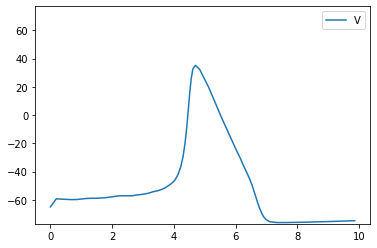

In [14]:
plotHistory_largescale(Histories[1],['V']) #grafica V(t), mostrando siempre entree -77mV y 77mV

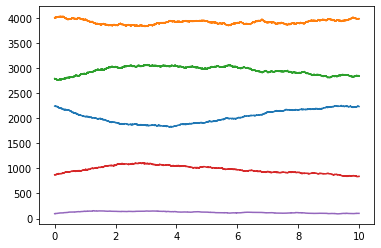

In [24]:
plotHistory(Histories[0],Id,0,5) #grafica los canales de K en el tiempo

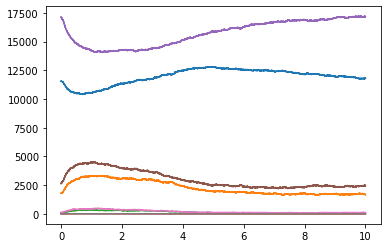

In [25]:
plotHistory(Histories[0],Id,5) #grafica los canales de Na en el tiempo

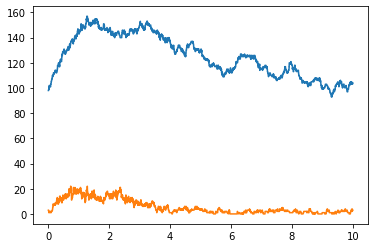

In [26]:
#Grafica juntos los canales totalmente abiertos de K y Na en el tiempo
plotHistory(Histories[0],Id,4,5)
plotHistory(Histories[0],Id,12,13)

In [27]:
#Para medir la ampliud del PA
TAU = list(Histories[1].keys())
Volt=np.zeros(len(TAU))
i=0
for t in TAU:
    Volt[i] = Histories[1][t]
    i =i+1
print('El pico del PA se alcanza en', max(Volt))

El pico del PA se alcanza en -58.96035761846018


In [ ]:
#Para obtener datos estadísticos sobre los intervalos tau

TAU = list(Histories[0].keys())
for i in range(len(TAU)-1):
    TAU[i] = TAU[i+1] - TAU[i] 
TAU[-1] = 0
print('tau =', mean(TAU), '+-', std(TAU))

In [72]:
#Funciones para calcular frecuencia de disparo. spike_count da una lista de los picos y su ubicacion. Su largo puede usarse junto con un gráfico como confirmación simple
def spike_count(history,V_filter=0): #los len()-1 son porque si llega a pasar algo en el ultimo valor hay error
    Pikes={}
    index=list(history.keys())
    for i in range(len(index)-1):
        if history[index[i]]>V_filter:
            if (history[index[i]] > history[index[i-1]]) & (history[index[i]]>history[index[i+1]]):
                Pikes[index[i]] = history[index[i]]
    return Pikes

def spike_rate_stat(history,V_filter=0):
    Pikes=[]
    index=list(history.keys())
    for i in range(len(index)-1):
        if history[index[i]]>V_filter:
            if (history[index[i]]>history[index[i-1]]) & (history[index[i]]>history[index[i+1]]):
                Pikes.append(index[i])
    Rates = []
    for j in range(len(Pikes)-1):
        Rates.append(1000/(Pikes[j+1] - Pikes[j])) #el 1000 es porque está todo en ms, para que quede en Hz
    return Rates

In [88]:
Q_1=ar([4,7,5,2,0,21,3,0,0,31,5,0,0])
Q_10=ar([40,72,50,16,2,208,32,2,0,308,48,2,0])
Q_25=ar([101,180,126,39,4,520,81,4,0,770,119,6,0])
Q_50=ar([202,359,251,79,9,1041,161,8,0,1540,238,12,0])
Q_75=ar([303,540,377,117,13,1560,241,13,0,2310,357,19,0])
Q_100=ar([404,720,502,157,17,2081,322,16,0,3080,476,24,1])

Q_200=ar([807,1441,1004,314,34,4162,644,33,0,6160,952,48,1])
Q_400=ar([1614,2882,2008,628,68,8323,1288,66,1,12320,1904,96,2])

V0 = -65 #V inicial, en mV. Vrest=-65mV
C = rates_update(V0) 
t_max = 200

9
La tasa de disparo es 63.002015790911535 +- 26.56958404176394 Hz


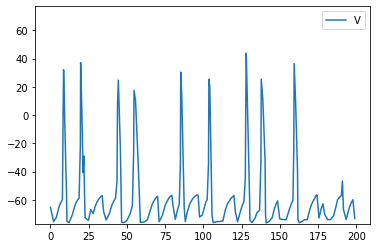

In [92]:
Histories_1 = GillespieHH(Q_1,R,C,0,t_max,V0,0,0)
plotHistory_largescale(Histories_1[1],['V'])

print(len(spike_count(Histories_1[1])))
print('La tasa de disparo es', mean(spike_rate_stat(Histories_1[1])) ,'+-',std(spike_rate_stat(Histories_1[1])),'Hz')

7
La tasa de disparo es 40.25538472006731 +- 16.428803389174686 Hz


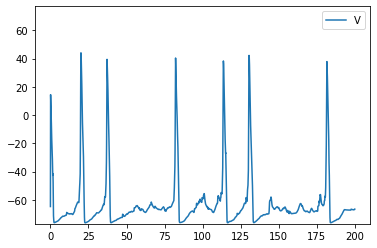

In [71]:
Histories_10 = GillespieHH(Q_10,R,C,0,t_max,V0,0,0)
plotHistory_largescale(Histories_10[1],['V'])

print(len(spike_count(Histories_10[1])))
print('La tasa de disparo es', mean(spike_rate_stat(Histories_10[1])) ,'+-',std(spike_rate_stat(Histories_10[1])),'Hz')

6
La tasa de disparo es 46.38591427794283 +- 15.589840697402789 Hz


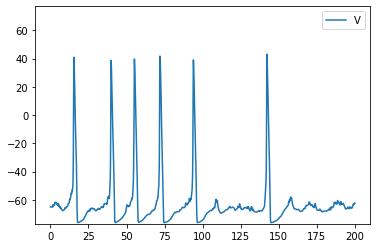

In [90]:
Histories_25 = GillespieHH(Q_25,R,C,0,t_max,V0,0,0)
plotHistory_largescale(Histories_25[1],['V'])

print(len(spike_count(Histories_25[1])))
print('La tasa de disparo es', mean(spike_rate_stat(Histories_25[1])) ,'+-',std(spike_rate_stat(Histories_25[1])),'Hz')

4
La tasa de disparo es 23.569669545789537 +- 11.667333216608997 Hz


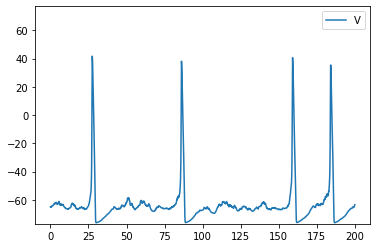

In [75]:
Histories_50 = GillespieHH(Q_50,R,C,0,t_max,V0,0,0)
plotHistory_largescale(Histories_50[1],['V'])

print(len(spike_count(Histories_50[1])))
print('La tasa de disparo es', mean(spike_rate_stat(Histories_50[1])) ,'+-',std(spike_rate_stat(Histories_50[1])),'Hz')

4
La tasa de disparo es 20.3873060959083 +- 2.1675852974390426 Hz


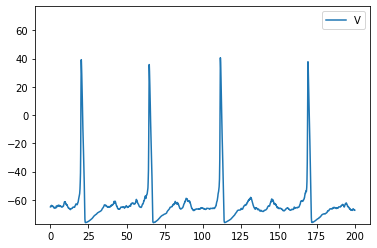

In [91]:
Histories_75 = GillespieHH(Q_75,R,C,0,t_max,V0,0,0)
plotHistory_largescale(Histories_75[1],['V'])

print(len(spike_count(Histories_75[1])))
print('La tasa de disparo es', mean(spike_rate_stat(Histories_75[1])) ,'+-',std(spike_rate_stat(Histories_75[1])),'Hz')

4
La tasa de disparo es 8.79015457157408 +- 2.2568706505409075 Hz


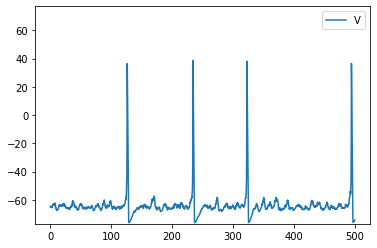

In [77]:
Histories_100 = GillespieHH(Q_100,R,C,0,500,V0,0,0)
plotHistory_largescale(Histories_100[1],['V'])

print(len(spike_count(Histories_100[1])))
print('La tasa de disparo es', mean(spike_rate_stat(Histories_100[1])) ,'+-',std(spike_rate_stat(Histories_100[1])),'Hz')